In [33]:
import numpy as np

# Dictionary for lattice constant (Angstrom)
lattice_dict = {
    ('Mo', 'S'):   3.16,
    ('Mo', 'Se'):  3.29,
    ('Mo', 'Te'):  3.4915,
    ('W',  'S'):   3.16,
    ('W',  'Se'):  3.29,
}

def primitive_vector_length(a, N, M):
    """
    Calculate the length of the supercell primitive vector.
    """
    return a * np.sqrt(N**2 + N*M + M**2)

def total_atoms(Nt, Mt, Nb, Mb):
    """
    Calculate the total number of atoms in both top and bottom supercells.
    """
    return 3*(Nt**2 + Nt*Mt + Mt**2) + 3*(Nb**2 + Nb*Mb + Mb**2)

def moire_angle(Nt, Mt, Nb, Mb):
    """
    Calculate the moiré angle between the top and bottom layers.
    """
    numerator = Nt*Nb + 0.5*Nt*Mb + 0.5*Mt*Nb + Mt*Mb
    denom = (np.sqrt(Nt**2 + Nt*Mt + Mt**2) *
             np.sqrt(Nb**2 + Nb*Mb + Mb**2))
    cos_theta = numerator / denom if denom > 1e-12 else 1.0
    cos_theta = np.clip(cos_theta, -1, 1)
    angle_deg = np.arccos(cos_theta) * 180 / np.pi
    return angle_deg

def scan_heterobilayer_avg(
    top_M='Mo', top_X='S',
    bot_M='Mo', bot_X='S',
    strain_limit=1.0,     # Percent
    Nmax=20, Mmax=20,
    min_atoms=0, max_atoms=1_000_000,
    min_angle=0.0, max_angle=1.0    # degree
):
    """
    Scan all possible (N, M) combinations for both layers,
    and output all supercells where required strain is within the limit.
    Strain is distributed so both supercell vectors match the average length.
    """
    a_t = lattice_dict[(top_M, top_X)]
    a_b = lattice_dict[(bot_M, bot_X)]
    results = []
    for Nt in range(1, Nmax+1):
        for Mt in range(0, Nt):
            for Nb in range(1, Nmax+1):
                for Mb in range(0, Nb):
                    # Compute original supercell vector length
                    ut = primitive_vector_length(a_t, Nt, Mt)
                    ub = primitive_vector_length(a_b, Nb, Mb)
                    uavg = (ut + ub) / 2.0
                    # Strain is calculated to force both vectors to the same average
                    strain_t = (uavg / ut) - 1.0
                    strain_b = (uavg / ub) - 1.0
                    atoms = total_atoms(Nt, Mt, Nb, Mb)
                    angle = moire_angle(Nt, Mt, Nb, Mb)
                    # Only output if strain, atom count, and angle are all within limits
                    if (abs(strain_t*100) < strain_limit and abs(strain_b*100) < strain_limit and
                        min_atoms <= atoms <= max_atoms and
                        min_angle <= angle <= max_angle):
                        results.append({
                            'Nt': Nt, 'Mt': Mt,
                            'Nb': Nb, 'Mb': Mb,
                            'strain_t(%)': strain_t*100,
                            'strain_b(%)': strain_b*100,
                            'moire_angle(deg)': angle,
                            'total_atoms': int(atoms)
                        })
    return results

# Example usage: only show results with moire angle between 0 and 3 degrees
top_M, top_X = 'W', 'S'
bot_M, bot_X = 'W', 'Se'
strain_limit = 1.0
Nmax = 20
min_atoms = 1000
max_atoms = 1200
min_angle = 0.0
max_angle = 3.0

results = scan_heterobilayer_avg(
    top_M, top_X, bot_M, bot_X,
    strain_limit=strain_limit,
    Nmax=Nmax, Mmax=Nmax,
    min_atoms=min_atoms, max_atoms=max_atoms,
    min_angle=min_angle, max_angle=max_angle
)

print(f"Nt Mt Nb Mb  strain_t(%)  strain_b(%)  moire_angle(deg)  total_atoms")
for r in results:
    print(f"{r['Nt']:2d} {r['Mt']:2d} {r['Nb']:2d} {r['Mb']:2d}   "
          f"{r['strain_t(%)']:+.7f}   {r['strain_b(%)']:+.7f}    "
          f"{r['moire_angle(deg)']:.3f}    {r['total_atoms']}")

# To save as CSV:
# import pandas as pd
# pd.DataFrame(results).to_csv("moiré_scan_results_with_angle.csv", index=False)

Nt Mt Nb Mb  strain_t(%)  strain_b(%)  moire_angle(deg)  total_atoms
10  6 10  5   -0.8107945   +0.8241589    2.680    1113
11  5 11  4   -0.6007815   +0.6080881    2.863    1146


Structures combined (lattice match).


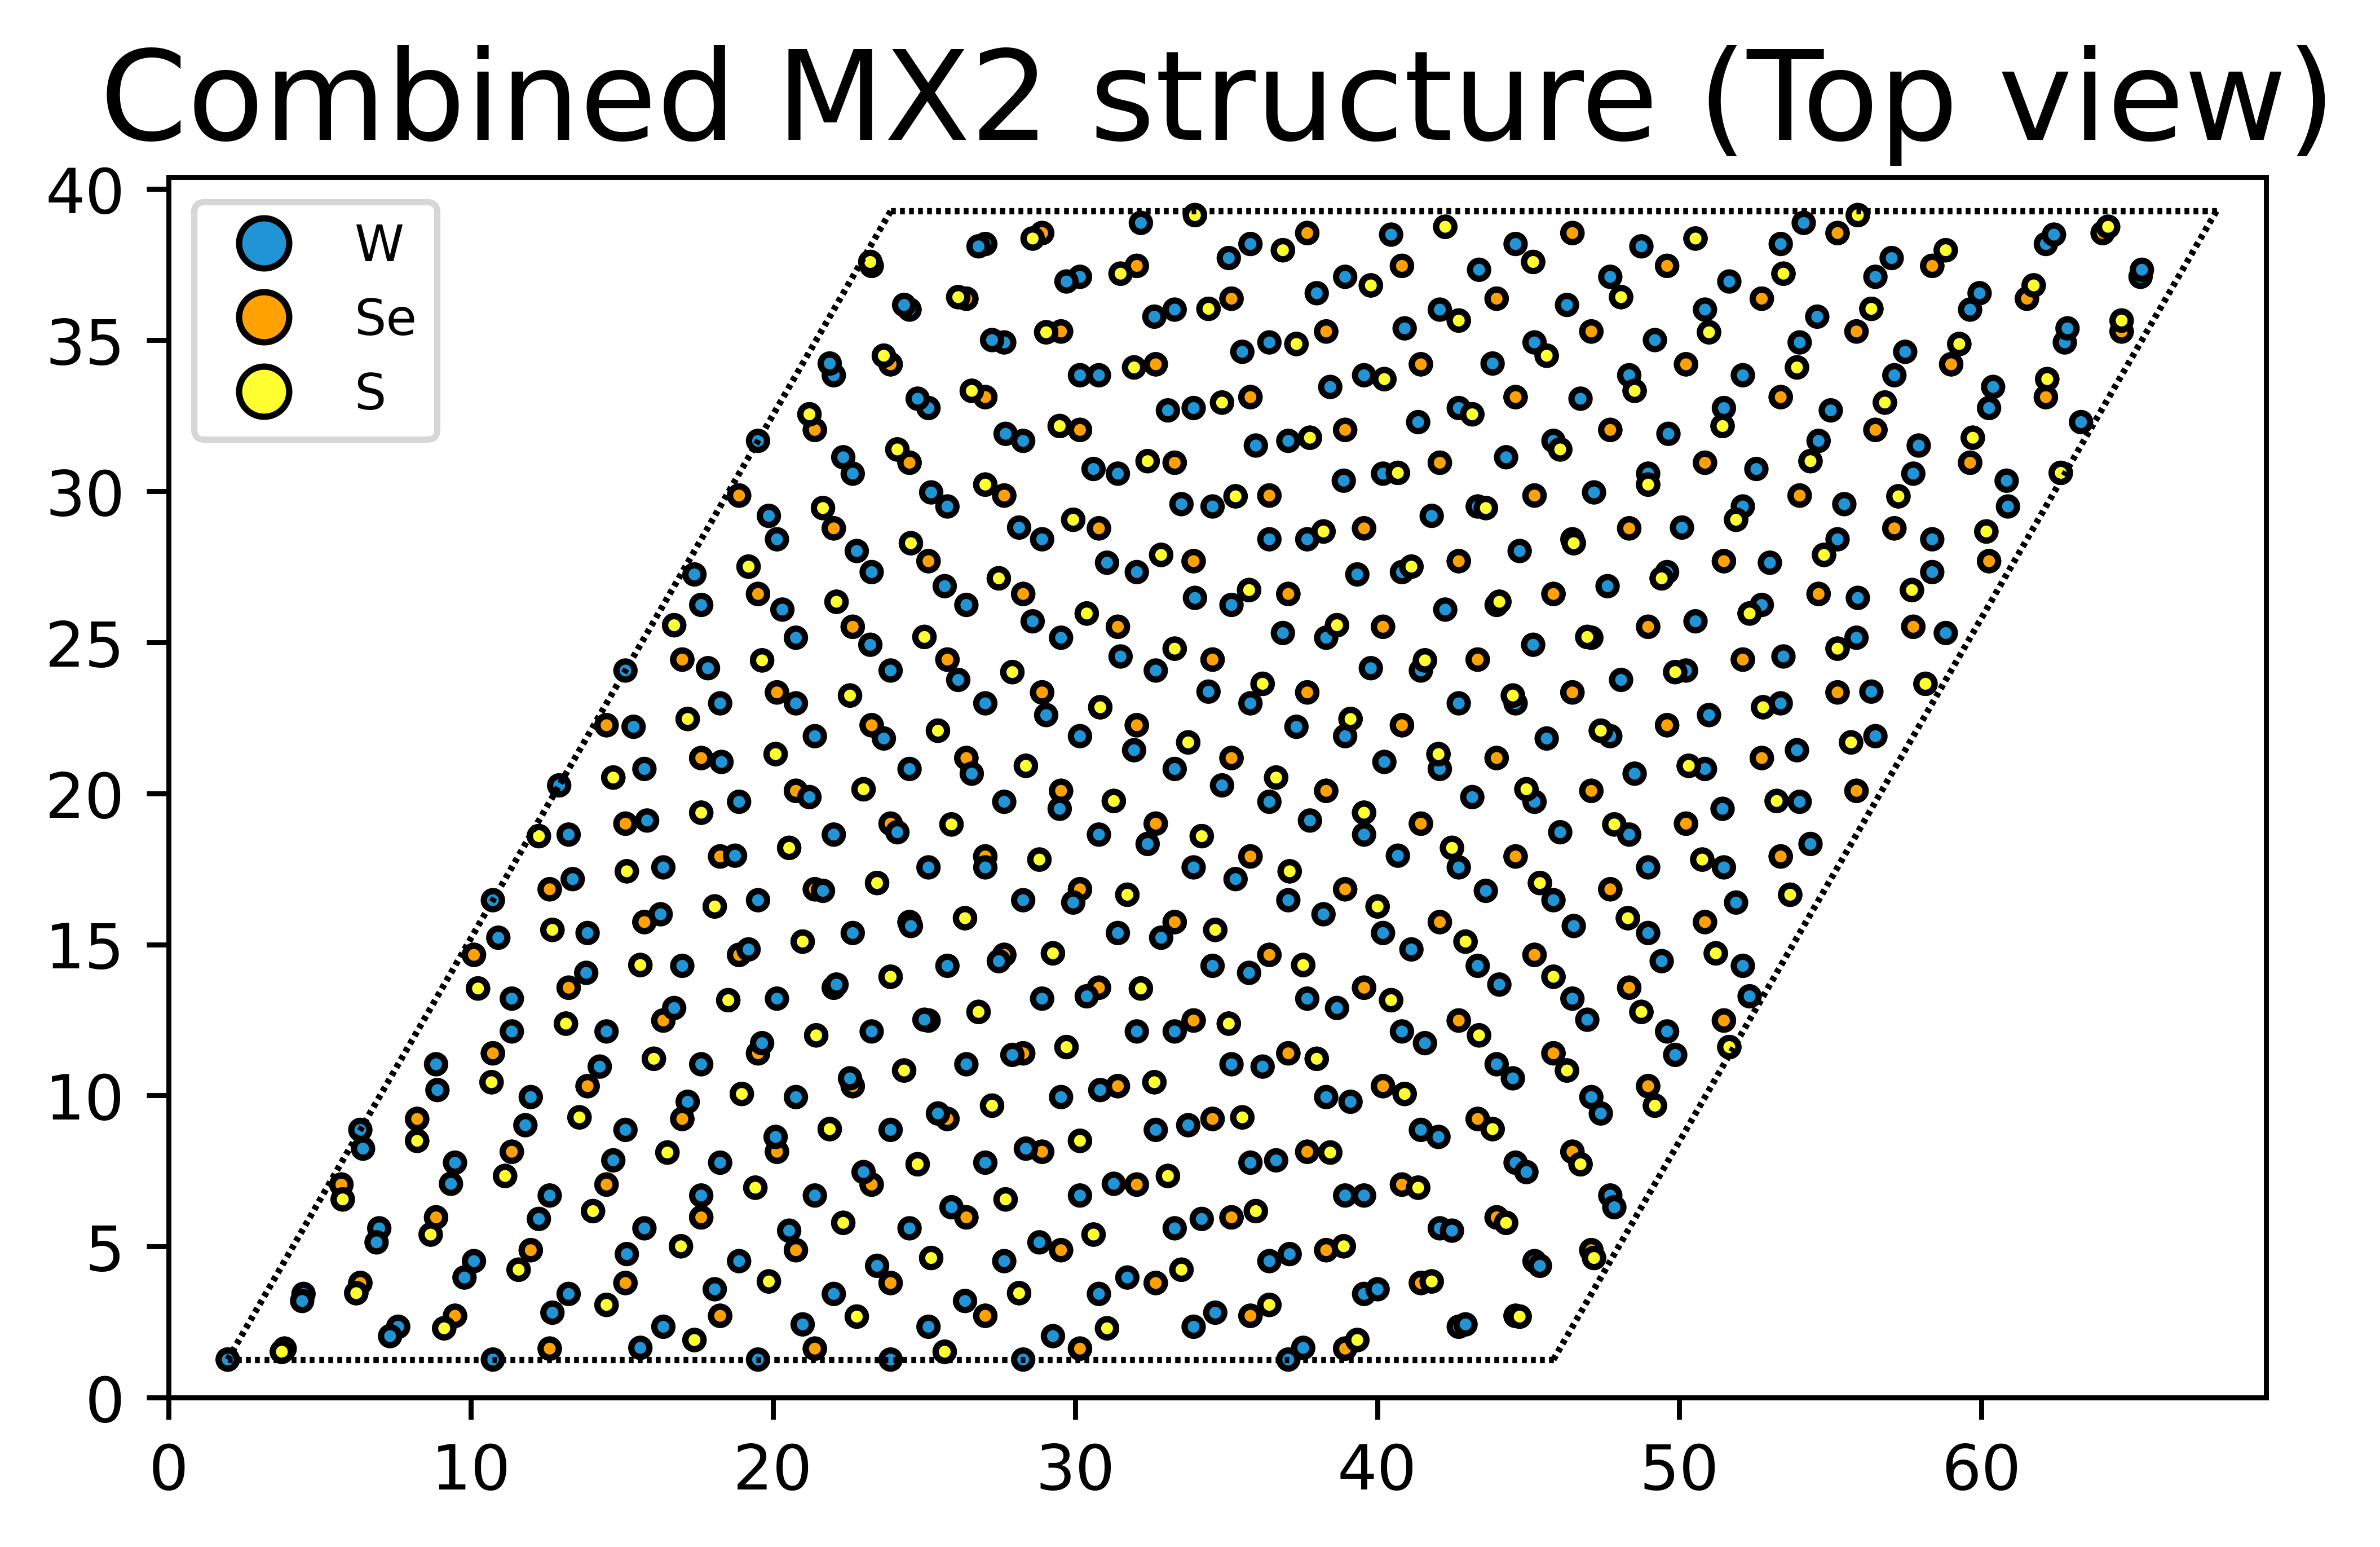

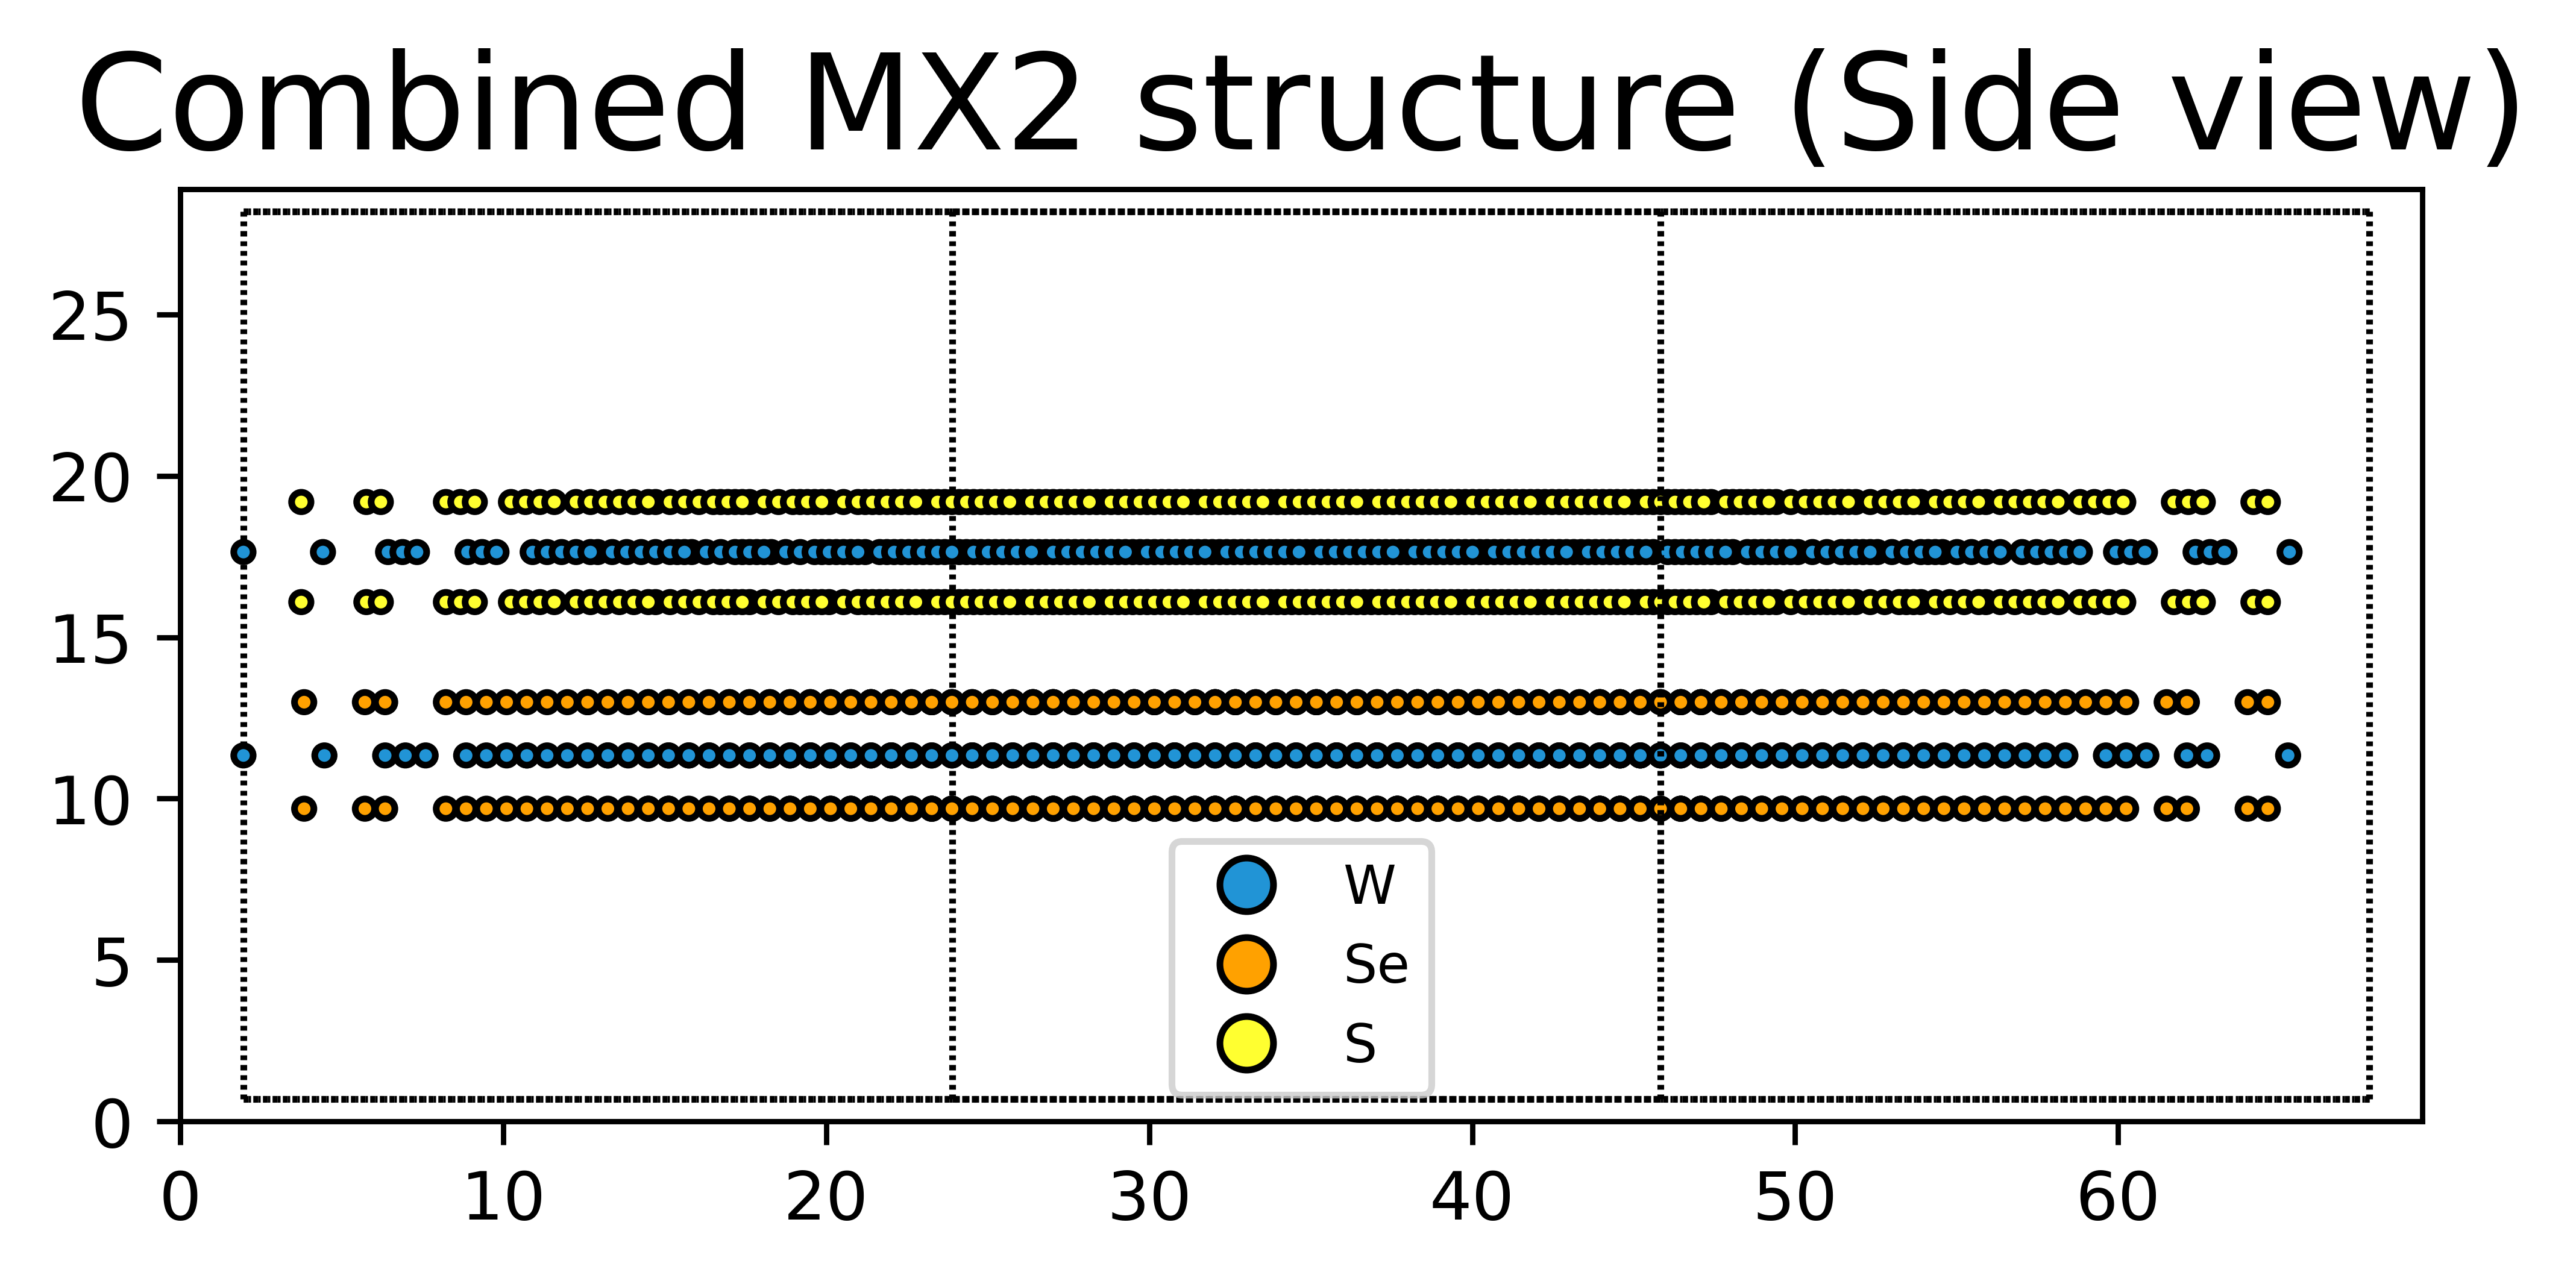

POSCAR written to «WS2_10_6_WSe2_10_5.vasp»


In [14]:
import numpy as np
from ase import Atoms
from ase.build import make_supercell
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from ase.data import atomic_numbers                         
from ase.data.colors import jmol_colors   
from ase.io import write                    
from matplotlib.lines import Line2D

plt.rcParams['figure.dpi'] = 800


# ---------- basic data helpers ----------
def get_layer_params(M, X):
    """Return (lattice a, X-X vertical distance, default inter-layer distance)."""
    lattice = {('Mo', 'S'): 3.16, ('Mo', 'Se'): 3.29, ('Mo', 'Te'): 3.4915,
               ('W',  'S'): 3.16, ('W',  'Se'): 3.29}
    xx_dist = {'S': 3.1, 'Se': 3.3, 'Te': 3.5}
    d_inter = {'S': 6.1, 'Se': 6.5, 'Te': 6.9}
    return lattice[(M, X)], xx_dist[X], d_inter[X]


# ---------- build one layer ----------
def build_layer(M, X, N_s, M_s, strain, vacuum,
                xx_bot, dI_bot, xx_top, dI_top, layer='bot'):
    """Return ASE Atoms object of one strained MX2 super-cell layer."""
    a, xx_self, dI_self = get_layer_params(M, X)
    a *= strain

    # unified c axis
    c_axis = (dI_bot + dI_top)/2 + (xx_bot + xx_top)/2 + vacuum

    # in-plane hexagon
    a1 = [a*np.sqrt(3)/2, -a/2, 0.0]
    a2 = [a*np.sqrt(3)/2,  a/2, 0.0]
    cell = [a1, a2, [0, 0, c_axis]]

    # unified z0
    z0_bot = (vacuum + xx_bot) / 2
    z0 = z0_bot if layer == 'bot' else z0_bot + (dI_bot + dI_top)/2

    # choose correct X-X separation for this layer
    xx_use = xx_bot if layer == 'bot' else xx_top
    zM  = z0
    zX1 = z0 + xx_use/2
    zX2 = z0 - xx_use/2

    atoms = Atoms(symbols=[M, X, X],
                  positions=[[0, 0, zM],
                             [a/np.sqrt(3), 0, zX1],
                             [a/np.sqrt(3), 0, zX2]],
                  cell=cell, pbc=[True, True, True])

    # apply (N_s, M_s) super-cell
    P = np.array([[N_s,  M_s, 0],
                  [-M_s, N_s+M_s, 0],
                  [0,    0,      1]])
    sc = make_supercell(atoms, P)

    # rotate so b1 ‖ x
    b1_xy = np.array(sc.cell[0][:2])
    sc.rotate(-np.degrees(np.arctan2(*b1_xy[::-1])), 'z',
              center=(0, 0, 0), rotate_cell=True)
    return sc


# ---------- legend helper ----------
def add_ase_legend(ax, atoms, order=None, size=8):
    """
    Add legend whose colors exactly follow ASE's Jmol colors.
    """
    elems = atoms.get_chemical_symbols()
    unique = sorted(set(elems), key=lambda s: atomic_numbers[s])
    if order is not None:
        # keep only those in order list & preserve order
        unique = [e for e in order if e in unique]

    handles = []
    for el in unique:
        Z = atomic_numbers[el]
        col = tuple(jmol_colors[Z])        # exact color used by plot_atoms
        handles.append(Line2D([0], [0], marker='o', ms=size,
                              markerfacecolor=col, markeredgecolor='k',
                              linestyle='None', label=el))
    ax.legend(handles=handles, title="",
              fontsize=8, title_fontsize=8, loc='best')


# ---------- user input ----------
top_M, top_X = 'W', 'S'
bot_M, bot_X = 'W', 'Se'
vacuum = 18
top_N_s, top_M_s = 10, 6
bot_N_s, bot_M_s = 10, 5
top_strain = 1.0 - 0.008107945     # −0.8108 %
bot_strain = 1.0 + 0.008241589     # +0.8242 %

# shared geometric data
_, xx_top, dI_top = get_layer_params(top_M, top_X)
_, xx_bot, dI_bot = get_layer_params(bot_M, bot_X)

# build layers
bot = build_layer(bot_M, bot_X, bot_N_s, bot_M_s, bot_strain,
                  vacuum, xx_bot, dI_bot, xx_top, dI_top, layer='bot')
top = build_layer(top_M, top_X, top_N_s, top_M_s, top_strain,
                  vacuum, xx_bot, dI_bot, xx_top, dI_top, layer='top')

# ---------- plot ----------
if np.allclose(bot.cell, top.cell, atol=1e-6):
    combo = bot + top
    print("Structures combined (lattice match).")

    # --- top view ---
    fig, ax = plt.subplots(figsize=(6, 5))
    plot_atoms(combo, ax=ax, rotation=('0x,0y,0z'), radii=[0.3]*len(combo))
    add_ase_legend(ax, combo, order=['W', 'Se', 'S'])
    ax.set_title("Combined MX2 structure (Top view)", fontsize=20)
    plt.show()

    # --- side view ---
    fig, ax = plt.subplots(figsize=(6, 5))
    plot_atoms(combo, ax=ax, rotation=('-90x,0y,0z'), radii=[0.3]*len(combo))
    add_ase_legend(ax, combo, order=['W', 'Se', 'S'])
    ax.set_title("Combined MX2 structure (Side view)", fontsize=20)
    plt.show()

    bot_tag = f"{bot_M}{bot_X}2"
    top_tag = f"{top_M}{top_X}2"
    bot_NM_tag  = f"{bot_N_s}_{bot_M_s}"
    top_NM_tag  = f"{top_N_s}_{top_M_s}"
    vasp_name = f"{top_tag}_{top_NM_tag}_{bot_tag}_{bot_NM_tag}.vasp"
    write(vasp_name, combo, format='vasp', direct=True, vasp5=True, sort=True)
    print(f"POSCAR written to «{vasp_name}»")

else:
    print("Lattice (cell) not matched. Cannot combine structures.")
    print("Cell (bot):\n", bot.cell)
    print("Cell (top):\n", top.cell)

In [16]:
import numpy as np

# Use this script to input atomic coordinates found from VESTA
# and verify the moiré twist angle between two vectors.
def angle_between_vectors(x1, y1, x2, y2):
    # Create vectors from the coordinates
    v1 = np.array([x1, y1])
    v2 = np.array([x2, y2])
    # Compute the dot product
    dot_product = np.dot(v1, v2)
    # Compute the norms (lengths) of each vector
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    # Calculate cosine of the angle, clip for numerical stability
    cos_theta = np.clip(dot_product / (norm1 * norm2), -1.0, 1.0)
    # Convert angle from radians to degrees
    angle_deg = np.degrees(np.arccos(cos_theta))
    return angle_deg

# Example:
# Copy atomic coordinates from VESTA and input here to check the moiré angle.
x1, y1 = 7.16429, 1.03408
x2, y2 = 7.52251, 1.44771
print(angle_between_vectors(x1, y1, x2, y2))

2.680170811780166
